In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sympy as smp
from centrex_TlF_hamiltonian import states, hamiltonian
import centrex_TlF_couplings as couplings
import centrex_TlF_lindblad as lindblad
import matplotlib.pyplot as plt
import scipy.constants as cst
import pandas as pd

In [3]:
plt.rcParams.update({'font.size': 14})

In [4]:
def power_from_rabi_rectangle(Ω: complex, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> float:
    E = Ω*cst.hbar / (main_coupling * D)
    intensity = 1/2 * cst.c * cst.epsilon_0 * E ** 2
    P = intensity * (dx * dy)
    return P.real

def rabi_from_power_rectangle(power: float, main_coupling: complex, dx: float, dy: float, D: float = 2.6675506e-30) -> complex:
    intensity = power / (dx * dy)
    E = np.sqrt(intensity*2 / (cst.c * cst.epsilon_0))
    Ω = E * main_coupling * D / cst.hbar
    return Ω

In [5]:
def doppler_shift(velocity, frequency):
    """calculate the doppler shifted frequency
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
    Returns:
        float: doppler shifted frequency in Hz
    """
    return frequency * (1 + velocity / cst.c)


def velocity_to_detuning(velocity, frequency=1.103e15, Γ=2*np.pi*1.56e6):
    """convert velocity to detuning in units of Γ
    Args:
        velocity (float): velocity [m/s]
        frequency (float): frequency [Hz]
        Γ (float): Γ [2π⋅Hz]
    Returns:
        float: detuning in units of Γ
    """
    return (doppler_shift(velocity, frequency) - frequency) * 2 * np.pi / Γ

In [6]:
syspars = lindblad.SystemParameters(nprocs = 7, Γ=hamiltonian.Γ)

# J=1

In [8]:
J1_state = states.CoupledBasisState(
    J=1, F1=3/2, F=2, mF=2, I1=1/2, I2=1/2, P=-1, electronic_state = states.ElectronicState.X, Omega=0
)

possible_transitions = couplings.get_possible_optical_transitions(J1_state, [couplings.OpticalTransitionType.R])[0]

v_to_Γ = velocity_to_detuning(1)*syspars.Γ
odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    PZ0 = "square_wave(t, ωp, 0.)",
    PX0 = f"square_wave(t, ωp, {np.pi})",
    β = 0,
    ωphase = 0,
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

polarizations = [couplings.polarization_Z, couplings.polarization_X]
possible_transitions

[OpticalTransition(R(1) F1'=3/2 F'=1),
 OpticalTransition(R(1) F1'=3/2 F'=2),
 OpticalTransition(R(1) F1'=5/2 F'=2),
 OpticalTransition(R(1) F1'=5/2 F'=3)]

OpticalTransition(R(1) F1'=3/2 F'=1) => 1.36 photons


,"|B, J = 2, F₁ = 3/2, F = 1>"
states,
"|X, J = 1>",0.709421
"|X, J = 3>",0.290579


OpticalTransition(R(1) F1'=3/2 F'=2) => 3.39 photons


,"|B, J = 2, F₁ = 3/2, F = 2>"
states,
"|X, J = 1>",0.71186
"|X, J = 3>",0.28814


OpticalTransition(R(1) F1'=5/2 F'=2) => 2.07 photons


,"|B, J = 2, F₁ = 5/2, F = 2>"
states,
"|X, J = 1>",0.525
"|X, J = 3>",0.475


OpticalTransition(R(1) F1'=5/2 F'=3) => 2.08 photons


,"|B, J = 2, F₁ = 5/2, F = 3>"
states,
"|X, J = 1>",0.523521
"|X, J = 3>",0.476474
"|X, J = 5>",0.000004


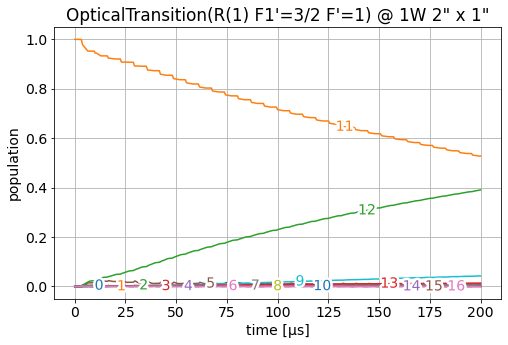

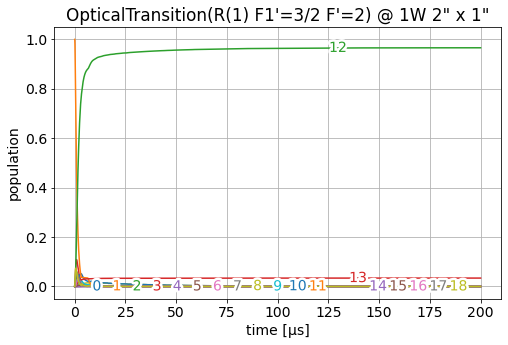

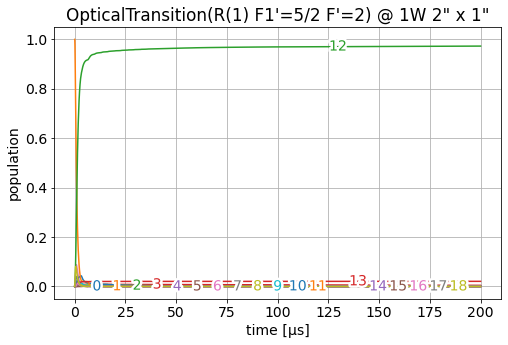

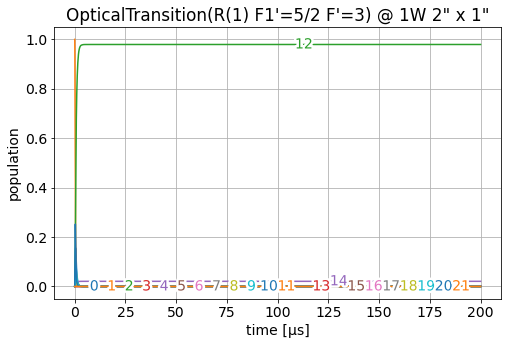

In [10]:
nphoton_data = {}

for transition in possible_transitions:
    transition_selectors = couplings.generate_transition_selectors([transition], [polarizations])
    
    decay_channels = [
        lindblad.DecayChannel(
            ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other", P=+1),
            excited = transition.qn_select_excited,
            branching = 1e-2,
            description = "vibrational decay"
        )
    ]
    
    obe_system = lindblad.setup_OBE_system_julia_transitions(
        syspars, odepars, [transition], transition_selectors, verbose=False, full_output=True,
        decay_channels = decay_channels
    )
    
    df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')
    
    ρ = states.population.generate_population_states(
        states.QuantumSelector(J=J1_state.J, F=J1_state.F, F1=J1_state.F1, mF=J1_state.mF, 
                                electronic = states.ElectronicState.X).get_indices(obe_system.QN), 
        len(obe_system.QN)
    )
    
    indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)
    
    rabi_1W = rabi_from_power_rectangle(1, np.abs(obe_system.couplings[0].main_coupling), 2.54e-2*2, 2.54e-2)

    odepars.ωphase = 0
    odepars.β = 0
    odepars.Ωl0 = rabi_1W
    odepars.ωp = 0.1*syspars.Γ
    
    result_single = lindblad.do_simulation_single(odepars, (0,200e-6), ρ)
    
    from labellines import labelLines

    fig, ax = plt.subplots(figsize = (8,5)) 
    ax.plot(result_single.t*1e6, result_single.y.T, label = np.arange(len(result_single.y)));
    ax.set_xlabel('time [μs]')
    ax.set_ylabel('population')
    
    ax.set_title(f'{transition} @ 1W 2" x 1"')
    
    labelLines(ax.get_lines(), zorder = 2.5, align = False, fontsize = 14)

    ax.grid(True)
    
    n_photons = np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ
    
    nphoton_data[str(transition).strip('OpticalTransition(').strip(')')] = n_photons
    
    print(f"{transition} => {n_photons:.2f} photons")
    display(df)

In [14]:
df_transitions = pd.DataFrame(
    data = {
        'states': list(nphoton_data.keys()),
        'photons': list(nphoton_data.values())
    }
)
df_transitions

,states,photons
0,R(1) F1'=3/2 F'=1,1.358198
1,R(1) F1'=3/2 F'=2,3.385258
2,R(1) F1'=5/2 F'=2,2.068818
3,R(1) F1'=5/2 F'=3,2.076807


# J=2 F=2

In [21]:
J2_state = states.CoupledBasisState(
    J=2, F1=5/2, F=2, mF=0, I1=1/2, I2=1/2, P=+1, electronic_state = states.ElectronicState.X, Omega=0
)

possible_transitions = couplings.get_possible_optical_transitions(
    J2_state, [couplings.OpticalTransitionType.R]
)[0]

possible_transitions

[OpticalTransition(R(2) F1'=5/2 F'=2),
 OpticalTransition(R(2) F1'=5/2 F'=3),
 OpticalTransition(R(2) F1'=7/2 F'=3)]

In [22]:
polarizations = [couplings.polarization_Z, couplings.polarization_X]

v_to_Γ = velocity_to_detuning(1)*syspars.Γ
odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    PZ0 = "square_wave(t, ωp, 0.)",
    PX0 = f"square_wave(t, ωp, {np.pi})",
    β = 0,
    ωphase = 0,
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

OpticalTransition(R(2) F1'=5/2 F'=2) => 2.61 photons


,"|B, J = 3, F₁ = 5/2, F = 2>"
states,
"|X, J = 0>",0.000010
"|X, J = 2>",0.624874
"|X, J = 4>",0.375116


OpticalTransition(R(2) F1'=5/2 F'=3) => 0.08 photons


,"|B, J = 3, F₁ = 5/2, F = 3>"
states,
"|X, J = 2>",0.625776
"|X, J = 4>",0.374224


OpticalTransition(R(2) F1'=7/2 F'=3) => 2.10 photons


,"|B, J = 3, F₁ = 7/2, F = 3>"
states,
"|X, J = 2>",0.530792
"|X, J = 4>",0.469208


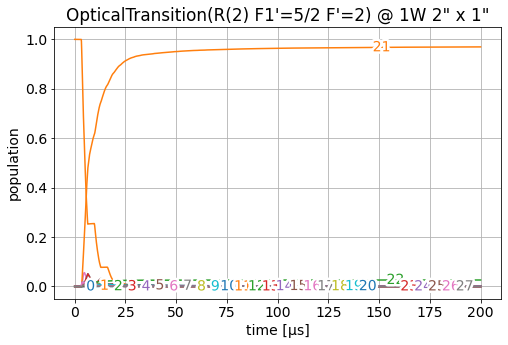

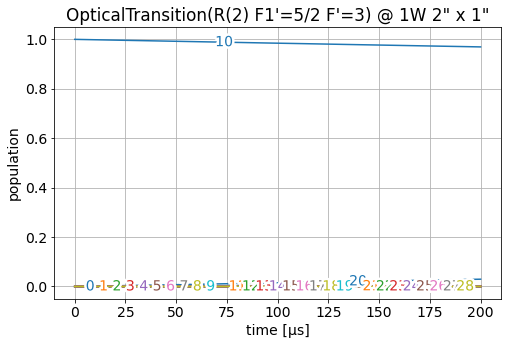

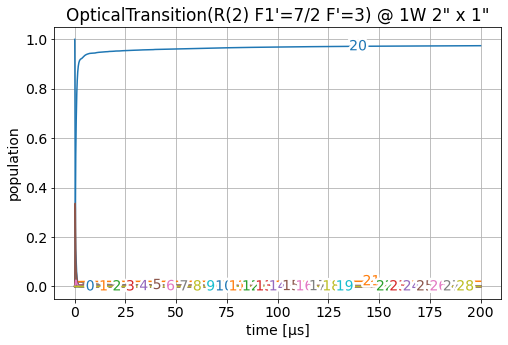

In [23]:
nphoton_data = {}

for transition in possible_transitions:
    transition_selectors = couplings.generate_transition_selectors([transition], [polarizations])
    
    decay_channels = [
        lindblad.DecayChannel(
            ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other", P=+1),
            excited = transition.qn_select_excited,
            branching = 1e-2,
            description = "vibrational decay"
        )
    ]
    
    obe_system = lindblad.setup_OBE_system_julia_transitions(
        syspars, odepars, [transition], transition_selectors, verbose=False, full_output=True,
        decay_channels = decay_channels
    )
    
    df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')

    ρ = states.population.generate_population_states(
        states.QuantumSelector(J=J2_state.J, F=J2_state.F, F1=J2_state.F1, mF=J2_state.mF, 
                                electronic = states.ElectronicState.X).get_indices(obe_system.QN), 
        len(obe_system.QN)
    )

    indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)

    rabi_1W = rabi_from_power_rectangle(1, np.abs(obe_system.couplings[0].main_coupling), 2.54e-2*2, 2.54e-2)

    odepars.ωphase = 0
    odepars.β = 0
    odepars.Ωl0 = rabi_1W
    odepars.ωp = 0.1*syspars.Γ

    result_single = lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

    from labellines import labelLines

    fig, ax = plt.subplots(figsize = (8,5)) 
    ax.plot(result_single.t*1e6, result_single.y.T, label = np.arange(len(result_single.y)));
    ax.set_xlabel('time [μs]')
    ax.set_ylabel('population')

    ax.set_title(f'{transition} @ 1W 2" x 1"')

    labelLines(ax.get_lines(), zorder = 2.5, align = False, fontsize = 14)

    ax.grid(True)
    
    n_photons = np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ
    
    nphoton_data[str(transition).strip('OpticalTransition(').strip(')')] = n_photons
    
    print(f"{transition} => {n_photons:.2f} photons")
    display(df)

In [24]:
df_transitions = pd.DataFrame(
    data = {
        'states': list(nphoton_data.keys()),
        'photons': list(nphoton_data.values())
    }
)
df_transitions

,states,photons
0,R(2) F1'=5/2 F'=2,2.608543
1,R(2) F1'=5/2 F'=3,0.079199
2,R(2) F1'=7/2 F'=3,2.097755


# J=2 F=3

In [25]:
J2_state = states.CoupledBasisState(
    J=2, F1=5/2, F=3, mF=0, I1=1/2, I2=1/2, P=+1, electronic_state = states.ElectronicState.X, Omega=0
)

possible_transitions = couplings.get_possible_optical_transitions(
    J2_state, [couplings.OpticalTransitionType.R]
)[0]

possible_transitions

[OpticalTransition(R(2) F1'=5/2 F'=2),
 OpticalTransition(R(2) F1'=5/2 F'=3),
 OpticalTransition(R(2) F1'=7/2 F'=3),
 OpticalTransition(R(2) F1'=7/2 F'=4)]

In [26]:
polarizations = [couplings.polarization_Z, couplings.polarization_X]

v_to_Γ = velocity_to_detuning(1)*syspars.Γ
odepars = lindblad.odeParameters(
    Ω0 = "Ωl0 * phase_modulation(t, β, ωphase)",
    Ωl0     = 1*syspars.Γ,    # Rabi frequency of the laser [rad/s]
    δ0      = f"vy*{v_to_Γ}",              # detuning of the laser [rad/s]

    # laser polarization switching
    ωp = 2*np.pi*1.56e6,           # polarization switching frequency [rad/s]
    PZ0 = "square_wave(t, ωp, 0.)",
    PX0 = f"square_wave(t, ωp, {np.pi})",
    β = 0,
    ωphase = 0,
    
    # molecules
    y0 = 0,                   # molecule start y position [m]
    vz = 184,                 # longitudinal molecular velocity [m/s]
    vy = 0,                   # molecule vy [m/s]
)

OpticalTransition(R(2) F1'=5/2 F'=2) => 1.32 photons


,"|B, J = 3, F₁ = 5/2, F = 2>"
states,
"|X, J = 0>",0.000010
"|X, J = 2>",0.624874
"|X, J = 4>",0.375116


OpticalTransition(R(2) F1'=5/2 F'=3) => 2.63 photons


,"|B, J = 3, F₁ = 5/2, F = 3>"
states,
"|X, J = 2>",0.625776
"|X, J = 4>",0.374224


OpticalTransition(R(2) F1'=7/2 F'=3) => 2.08 photons


,"|B, J = 3, F₁ = 7/2, F = 3>"
states,
"|X, J = 2>",0.530792
"|X, J = 4>",0.469208


OpticalTransition(R(2) F1'=7/2 F'=4) => 2.11 photons


,"|B, J = 3, F₁ = 7/2, F = 4>"
states,
"|X, J = 2>",0.530143
"|X, J = 4>",0.469856
"|X, J = 6>",0.000002


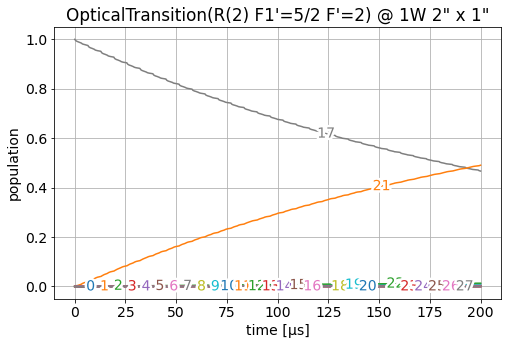

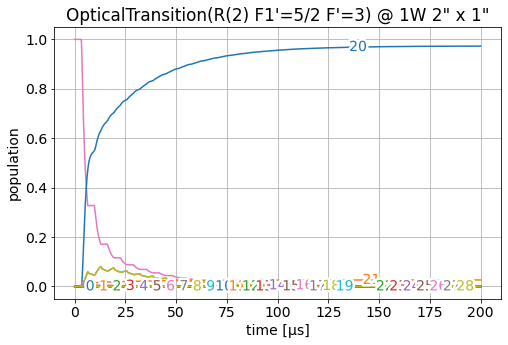

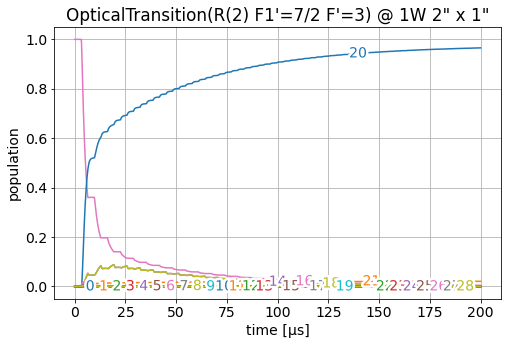

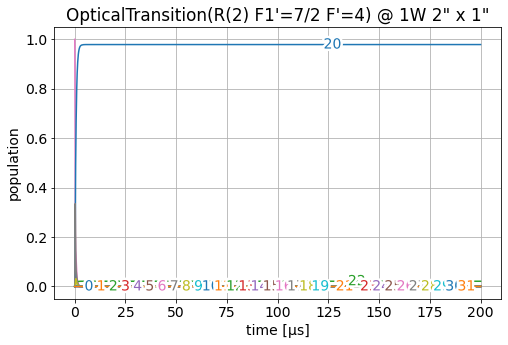

In [27]:
nphoton_data = {}

for transition in possible_transitions:
    transition_selectors = couplings.generate_transition_selectors([transition], [polarizations])
    
    decay_channels = [
        lindblad.DecayChannel(
            ground = 1*states.CoupledBasisState(None, None, None, None, None, None, v = "other", P=+1),
            excited = transition.qn_select_excited,
            branching = 1e-2,
            description = "vibrational decay"
        )
    ]
    
    obe_system = lindblad.setup_OBE_system_julia_transitions(
        syspars, odepars, [transition], transition_selectors, verbose=False, full_output=True,
        decay_channels = decay_channels
    )
    
    df = couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground='J')

    ρ = states.population.generate_population_states(
        states.QuantumSelector(J=J2_state.J, F=J2_state.F, F1=J2_state.F1, mF=J2_state.mF, 
                                electronic = states.ElectronicState.X).get_indices(obe_system.QN), 
        len(obe_system.QN)
    )

    indices_excited = transition.qn_select_excited.get_indices(obe_system.QN)

    rabi_1W = rabi_from_power_rectangle(1, np.abs(obe_system.couplings[0].main_coupling), 2.54e-2*2, 2.54e-2)

    odepars.ωphase = 0
    odepars.β = 0
    odepars.Ωl0 = rabi_1W
    odepars.ωp = 0.1*syspars.Γ

    result_single = lindblad.do_simulation_single(odepars, (0,200e-6), ρ)

    from labellines import labelLines

    fig, ax = plt.subplots(figsize = (8,5)) 
    ax.plot(result_single.t*1e6, result_single.y.T, label = np.arange(len(result_single.y)));
    ax.set_xlabel('time [μs]')
    ax.set_ylabel('population')

    ax.set_title(f'{transition} @ 1W 2" x 1"')

    labelLines(ax.get_lines(), zorder = 2.5, align = False, fontsize = 14)

    ax.grid(True)
    
    n_photons = np.trapz(result_single.y[indices_excited].sum(axis=0), x=result_single.t)*hamiltonian.Γ
    
    nphoton_data[str(transition).strip('OpticalTransition(').strip(')')] = n_photons
    
    print(f"{transition} => {n_photons:.2f} photons")
    display(df)

In [28]:
df_transitions = pd.DataFrame(
    data = {
        'states': list(nphoton_data.keys()),
        'photons': list(nphoton_data.values())
    }
)
df_transitions

,states,photons
0,R(2) F1'=5/2 F'=2,1.321172
1,R(2) F1'=5/2 F'=3,2.625093
2,R(2) F1'=7/2 F'=3,2.078740
3,R(2) F1'=7/2 F'=4,2.105439
